# Census Income, SVM, Precision
## Auguścik Szymon, Krzemińska Alicja

# Source code



## Preprocessing
At the beggining a preproccesing step has been carried out (e. g. changing `str` to `float`, imputing missing data, removing white spaces).

### First look at the dataset
The names of columns were assigned manually with respect to dataset description. 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer as Imputer
import os

# Download data

# URL for the Census Income Data Set (UCI Machine Learning Repository)
if not os.path.exists('adult.data'):
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
if not os.path.exists('adult.names'):
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
if not os.path.exists('adult.test'):
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

# column labels
names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']

# loading data
data = pd.read_csv("adult.data", header=None, names=names)
print(data.head(5))
test = pd.read_csv("adult.test", skiprows=1, header=None, names=names)
print(test.head(5))

# remove whitespaces and map ? to np.nan
for name in names:
  data[name] = data[name].astype(str).str.replace(' ', '')
  data[name].replace({'?' : np.nan}, inplace=True)

  test[name] = test[name].astype(str).str.replace(' ', '')
  test[name].replace({'?' : np.nan}, inplace=True)

# mapping <=50K salary to 0 and >50K to 1
data.replace({'salary': {'<=50K' : 0, '>50K' : 1}}, inplace=True)
test.replace({'salary': {'<=50K.' : 0, '>50K.' : 1}}, inplace=True)
print(data.head(10))
print(test.head(10))

--2021-03-27 15:49:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  7.32MB/s    in 0.5s    

2021-03-27 15:49:08 (7.32 MB/s) - ‘adult.data’ saved [3974305/3974305]

--2021-03-27 15:49:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names’

adult.names         100%[===================>]   5.11K  --.-KB/s    in 0s      

2021-

### Missing data
The `float` variables were corrected with mean value and the `str` variables - with median value. Some new data rows were presented below in order to check any changes.

In [ ]:
# SimpleImputer
names_median = ['age', 'fnlwgt',  'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'salary']
names_freq = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

for name in names:
  strategy = ''

  if name in names_median:
    strategy = 'median' 
  elif name in names_freq:
    strategy = 'most_frequent'
  
  imr = Imputer(missing_values=np.nan, strategy=strategy)
  imr = imr.fit(data[[name]])
  data[name] = imr.transform(data[[name]]).ravel()
  imr = imr.fit(test[[name]])
  test[name] = imr.transform(test[[name]]).ravel()

# some cases that initially lacked data 
print((data[data['age'] == 54]).iloc[1])
print((test[test['age'] == 18]).iloc[0])

age                               54
workclass                    Private
fnlwgt                        180211
education               Some-college
education-num                     10
marital-status    Married-civ-spouse
occupation            Prof-specialty
relationship                 Husband
race              Asian-Pac-Islander
sex                             Male
capital-gain                       0
capital-loss                       0
hours-per-week                    60
native-country                 South
salary                             1
Name: 27, dtype: object
age                           18
workclass                Private
fnlwgt                    103497
education           Some-college
education-num                 10
marital-status     Never-married
occupation        Prof-specialty
relationship           Own-child
race                       White
sex                       Female
capital-gain                   0
capital-loss                   0
hours-per-week           

### Training set description

In [ ]:
# no. of data columns (target column excluded)
print(len(data.columns) - 1)

# columns
print(data.dtypes)

# size
print(data.shape[0])

# target
print(data[['salary']].head())

# no. of <=50K and >50K
print(f"Less or equal than 50K: {data[data['salary'] == 0].shape[0]}")
print(f"More than 50K: {data[data['salary'] == 1].shape[0]}")

14
age               float64
workclass          object
fnlwgt            float64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country     object
salary            float64
dtype: object
32561
   salary
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
Less or equal than 50K: 24720
More than 50K: 7841


### Test set description

In [ ]:
# size
print(test.shape[0])

# no. of <=50K and >50K
print(f"Less or equal than 50K: {test[test['salary'] == 0].shape[0]}")
print(f"More than 50K: {test[test['salary'] == 1].shape[0]}")

16281
Less or equal than 50K: 12435
More than 50K: 3846


### Mapping string to float
In this part `str` values were mapped into `float` - without this step it would be impossible to fit a model. 

In [ ]:
# mapping string to float

data_mapped = data.copy()
test_mapped = test.copy()

for name in names:
  if data[name].dtype != np.float64:
    data_mapped[name] = pd.Categorical(data_mapped[name], categories=data_mapped[name].unique()).codes
  if test[name].dtype != np.float64:
    test_mapped[name] = pd.Categorical(test_mapped[name], categories=test_mapped[name].unique()).codes

print(data.head(5))
print(data_mapped.head(5))
print(test.head(5))
print(test_mapped.head(5))

    age         workclass    fnlwgt  ... hours-per-week  native-country salary
0  39.0         State-gov   77516.0  ...           40.0   United-States    0.0
1  50.0  Self-emp-not-inc   83311.0  ...           13.0   United-States    0.0
2  38.0           Private  215646.0  ...           40.0   United-States    0.0
3  53.0           Private  234721.0  ...           40.0   United-States    0.0
4  28.0           Private  338409.0  ...           40.0            Cuba    0.0

[5 rows x 15 columns]
    age  workclass    fnlwgt  ...  hours-per-week  native-country  salary
0  39.0          0   77516.0  ...            40.0               0     0.0
1  50.0          1   83311.0  ...            13.0               0     0.0
2  38.0          2  215646.0  ...            40.0               0     0.0
3  53.0          2  234721.0  ...            40.0               0     0.0
4  28.0          2  338409.0  ...            40.0               1     0.0

[5 rows x 15 columns]
    age  workclass    fnlwgt  ... ho

## Machine learning process
After preparing data, model was trained with training set and it then tried to predict new values based on test set. The results were compared with using cross validation 10 times.

### Training and prediction
The precision of the model reached 96%. That means a majority of samples classified as positive (>50K) were indeed proper. In other words, if algorithm establishes that a person will earn more than 50K per year, it is correct in 96% of cases.

In [ ]:
# training
from sklearn.svm import SVC

classifier = SVC(random_state=42)

X_train = data_mapped.drop(columns=['salary']).to_numpy()
y_train = data_mapped['salary'].ravel()

classifier.fit(X_train, y_train) ;

In [ ]:
# predict
from sklearn.metrics import precision_score

X_test = test_mapped.drop(columns=['salary']).to_numpy()
y_test = test_mapped['salary'].ravel()

y_predict = classifier.predict(X_test)
precision = precision_score(y_test, y_predict)

print(f"Precision: {precision}")

Precision: 0.9644012944983819


### Evaluation
After cross validation the model got average precision equal 97% which is similar to test set score. One can say that this little gap (1 percentage point) means that model tends to overfit data - it could be true but it was assumed that the difference is too small to be a sign of overfitting.

Due to confusion matrix analysis it was conluded that model was trying to classify most of samples as negative (<=50K). The probable cause of its behaviour is the fact that both training and test sets are not balanced. There are about 3 times more people who won't earn 50K per year than people who will. That imbalance affects the process of learning.

In [ ]:
# cross validation
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, shuffle=True)
precision_scores = []

for train_idx, valid_idx in cv.split(X_train, y_train):
    X_t_f, X_v_f = X_train[train_idx], X_train[valid_idx]
    y_t_f, y_v_f = y_train[train_idx], y_train[valid_idx]

    clf = SVC(random_state=42)
    clf.fit(X_t_f, y_t_f)

    cv_precision = precision_score(y_v_f, clf.predict(X_v_f))
    precision_scores.append(cv_precision)

mean_precision = np.mean(precision_scores)
print(f"Mean precision: {mean_precision}")

Mean precision: 0.973454303379995


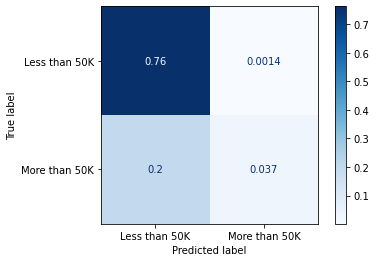

In [ ]:
# confusion matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

labels = ['Less than 50K', 'More than 50K']

def plot_conf_matrix(clf, X_test, y_test, labels, normalize=None):
  plot_confusion_matrix(clf, X_test, y_test, display_labels=labels, normalize=normalize,cmap=plt.cm.Blues)
  plt.show()

plot_conf_matrix(classifier, X_test, y_test, labels, 'all')

## Optimalization

### Hyperparameters
The optimal precision achieved during optimalization step equals 100%. Although the score seems to be perfect, it should raise concerns. Precision is vulnerable for non-balanced data and can cause misunderstanding of learning results. 

After taking a closer inspection of confusion matrix, another issue was discovered. Model tries to minimize the number of positive predictions in order to minimize false positive (FP) cases. The less FP cases, the higher accuracy score is. In addition, the number of false negative (FN) cases increased due to the fact that they do not impact precision.

Started fitting...
...Done!
Started predicting...
...Done!
Precision: 1.0
{'C': 10.0, 'kernel': 'rbf'}


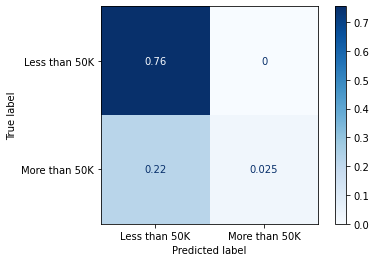

In [ ]:
# hyper-parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

parameters = {
    'kernel' : ['linear', 'poly', 'rbf'], # this line is time-consuming
    'C' : [0.1, 1.0, 5.0, 10.0]
}

batch_data = 1000
batch_test = 200

scorer = make_scorer(precision_score, zero_division=0)
gcv = GridSearchCV(classifier, parameters, scoring=scorer)

print("Started fitting...")
gcv.fit(X_train[:batch_data,:], y_train[:batch_data])
print("...Done!")

print("Started predicting...")
y_grid = gcv.predict(X_test[:batch_test,:])
print("...Done!")

optimal_precision = precision_score(y_test[:batch_test], y_grid)
print(f"Precision: {optimal_precision}")
print(gcv.best_params_)

plot_conf_matrix(gcv, X_test[:batch_test,:], y_test[:batch_test], labels, 'all')

### Advanced data preprocessing

#### Transformer for standarization and normalization

In [ ]:
# create custom transformer

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, Normalizer


class StandNormTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, standarization: bool = False, normalization: bool = False):
        self.standarization = standarization
        self.normalization = normalization
        self._features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                          'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
                          'native-country']
        self._numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_df = pd.DataFrame(X.copy(), columns=self._features)
        numerical_data = X_df[self._numerical_features].to_numpy()
  
        if self.standarization and self.normalization:
            numerical_data = self._normalize(self._standarize(numerical_data))

        if self.standarization:
            numerical_data = self._standarize(numerical_data)

        if self.normalization:
            numerical_data = self._normalize(numerical_data)

        numerical_df = pd.DataFrame(numerical_data, columns=self._numerical_features)
        X_df[self._numerical_features] = numerical_df

        return X_df.to_numpy()

    def _standarize(self, numerical_data):
        scaler = StandardScaler().fit(numerical_data)
        return scaler.transform(numerical_data)

    def _normalize(self, numerical_data):
        scaler = Normalizer().fit(numerical_data)
        return scaler.transform(numerical_data)


#### Impact of normalization, standarization and PCA on model
After more sophisticated optimalization precision reached 100% again. On the other hand, number of FN was reduced a little.

Started fitting...
...Done!
Started predicting...
...Done!
Precision: 1.0
{'pca__n_components': 5, 'preprocessing__normalization': False, 'preprocessing__standarization': False, 'svc__C': 5.0, 'svc__kernel': 'rbf'}


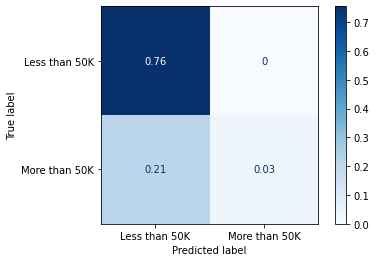

In [ ]:
# normalization, standarization, PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

pipe = Pipeline([('preprocessing', StandNormTransformer()), ('pca', PCA()), ('svc', SVC())])
                 
param_grid = {
    'preprocessing__standarization': [True, False],
    'preprocessing__normalization': [True, False],
    'pca__n_components': [5, 8, 10, 14],
    'svc__kernel' : ['rbf'], # to simplify calculations
    'svc__C' : [0.1, 1.0, 5.0, 10.0]
}

batch_data = 1000
batch_test = 200

scorer = make_scorer(precision_score, zero_division=0)
gcv = GridSearchCV(pipe, param_grid, scoring=scorer)

print("Started fitting...")
gcv.fit(X_train[:batch_data,:], y_train[:batch_data])
print("...Done!")

standarization = gcv.best_params_['preprocessing__standarization']
normalization = gcv.best_params_['preprocessing__normalization']
transformer = StandNormTransformer(standarization, normalization)
X_test = transformer.transform(X_test)

print("Started predicting...")
y_grid = gcv.predict(X_test[:batch_test,:])
print("...Done!")

optimal_precision = precision_score(y_test[:batch_test], y_grid)
print(f"Precision: {optimal_precision}")
print(gcv.best_params_)

plot_conf_matrix(gcv, X_test[:batch_test,:], y_test[:batch_test], labels, 'all')